In [12]:
import os, pickle
import numpy as np
from oct2py import Oct2Py
import cyipopt
import warnings
from tqdm import trange
from pypower.ext2int import ext2int
from pypower.api import loadcase
from problemDefJITM import opfSocp
from problemDefJITMargin import opfSocpMargin

# get octave object
octave = Oct2Py()
# filter warnings
warnings.simplefilter("ignore", np.ComplexWarning)

# user options 
MAX_BUS = 10000 # upper limit of number of buses in cases to be considered
NUM_POINTS = 100 # number of data points to save

# main

if __name__ == "__main__":

    # get all cases in current directory
    current_directory = os.getcwd()+'/'
    # current_directory = '/home/sbose/pglib-opf/' # for running on BEBOP
    all_files_and_directories = os.listdir(current_directory)
    # three specific cases
    case_files = [current_directory+i for i in ['pglib_opf_case2312_goc.m',"pglib_opf_case4601_goc.m","pglib_opf_case10000_goc.m"]]

    cases, casenames = [], []
    cases_full, casenames_full = [], []
    for cf in case_files:
        octave.source(current_directory+os.path.basename(cf))
        cname = os.path.basename(cf).split('.')[0]
        num_buses = None
        # determine number of buses in the case from its name
        for ci in cname.split('_'):
            if 'case' in ci:
                num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
        # fitler out cases with more buses than MAX_BUS
        if num_buses <= MAX_BUS:
            # convert to internal indexing
            case_correct_idx = ext2int(loadcase(octave.feval(cname)))
            # append
            cases.append(case_correct_idx)
            casenames.append(cname)
            
    # generate upper and lower bound
            
    # solve
    for cn,this_case in zip(casenames,cases):
        
        # generate lower bound of power demand margin
        optObj = opfSocpMargin(this_case,cn,margin_sense=1)
        cub, clb = optObj.calc_cons_bounds()
        xub, xlb = optObj.calc_var_bounds()
        # Define IPOPT problem
        probMargin = cyipopt.Problem(
            n = optObj.in_size,
            m = optObj.cons_size,
            problem_obj=optObj,
            lb=xlb,
            ub=xub,
            cl=clb,
            cu=cub
        )
        # Setup solver options
        probMargin.add_option('tol',1e-6)
        probMargin.add_option('max_iter',2500)
        probMargin.add_option('mumps_mem_percent',25000)
        probMargin.add_option('mu_max',1e-0)
        probMargin.add_option('mu_init',1e-0)
        probMargin.add_option('nlp_lower_bound_inf',-optObj.LARGE_NUMBER+1)
        probMargin.add_option('nlp_upper_bound_inf',optObj.LARGE_NUMBER-1)
        probMargin.add_option('print_level',2)
        # solve
        x, info = probMargin.solve(optObj.calc_x0_flatstart())  
        _maxMarginPd = x[optObj.vidx['mPd']]
        _maxMarginQd = x[optObj.vidx['mQd']]
        
        # generate lower bound of power demand margin
        optObj = opfSocpMargin(this_case,cn,margin_sense=-1)
        cub, clb = optObj.calc_cons_bounds()
        xub, xlb = optObj.calc_var_bounds()
        # Define IPOPT problem
        probMargin = cyipopt.Problem(
            n = optObj.in_size,
            m = optObj.cons_size,
            problem_obj=optObj,
            lb=xlb,
            ub=xub,
            cl=clb,
            cu=cub
        )
        # Setup solver options
        probMargin.add_option('tol',1e-6)
        probMargin.add_option('max_iter',2500)
        probMargin.add_option('mumps_mem_percent',25000)
        probMargin.add_option('mu_max',1e-0)
        probMargin.add_option('mu_init',1e-0)
        probMargin.add_option('nlp_lower_bound_inf',-optObj.LARGE_NUMBER+1)
        probMargin.add_option('nlp_upper_bound_inf',optObj.LARGE_NUMBER-1)
        probMargin.add_option('print_level',4)
        # solve
        x, info = probMargin.solve(optObj.calc_x0_flatstart())  
        _minMarginPd = x[optObj.vidx['mPd']]
        _minMarginQd = x[optObj.vidx['mQd']]
        
        # filter the min/max
        maxMarginPd = np.minimum(_minMarginPd,_maxMarginPd)
        minMarginPd = maxMarginPd
        maxMarginQd = np.minimum(_minMarginQd,_maxMarginQd)
        minMarginQd = maxMarginQd
        
        # solve base problem
        print(f"\n--------\nSolving {cn}.\n--------\n",flush=True)
        optObj = opfSocp(this_case,cn)
        cub, clb = optObj.calc_cons_bounds()
        xub, xlb = optObj.calc_var_bounds()
        
        # Define IPOPT problem
        prob = cyipopt.Problem(
            n = optObj.in_size,
            m = optObj.cons_size,
            problem_obj=optObj,
            lb=xlb,
            ub=xub,
            cl=clb,
            cu=cub
        )
        
        # Setup solver options
        prob.add_option('tol',1e-6)
        prob.add_option('max_iter',2500)
        prob.add_option('mumps_mem_percent',25000)
        prob.add_option('mu_max',1e-1)  
        prob.add_option('mu_init',1e-1)
        prob.add_option('print_level',4)
        
        # Solve ipopt problem
        _, info_base = prob.solve(optObj.calc_x0_flatstart())
        
        # generate points
        data = []
        prob.add_option('mu_init',1e-7)
        
        # get pd, qd and perturb
        pd,qd = optObj.get_loads()
        pd_up, pd_down = pd + maxMarginPd, pd - minMarginPd
        qd_up, qd_down = qd + maxMarginQd, qd - minMarginQd
            
        
        for pt_idx in trange(NUM_POINTS):
            
            # set random seed
            np.random.seed(pt_idx)
            
            dpd, dqd = pd_down + np.random.rand(*pd.shape)*(pd_up-pd_down), qd_down + np.random.rand(*qd.shape)*(qd_up-qd_down)
            optObj.change_loads(dpd,dqd)
            
            # generate input dicts
            input_data = {'pd':pd,'qd':qd,'flow_lim':optObj.flow_lim,'angmin':optObj.angmin,'angmax':optObj.angmax}
            
            print("Solving {pt_idx}th ")
            # solve problem
            _, info = prob.solve(optObj.calc_x0_flatstart())
            data.append((input_data,info))
            
        # save data
        with open(os.getcws()+f'/{cn}_data.pkl','wb') as file:
            pickle.dump(data,file)

Total number of variables............................:    25466
                     variables with only lower bounds:     4624
                variables with lower and upper bounds:    20842
                     variables with only upper bounds:        0
Total number of equality constraints.................:    16676
Total number of inequality constraints...............:    15065
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:    15065


Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:  -1.8983979350810201e+04   -1.8983979350810201e+04
Dual infeasibility......:   4.2460846187325429e-08    4.2460846187325429e-08
Constraint violation....:   5.9181750409400338e-14    1.8189894035458565e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

  0%|                                                                                                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

Solving {pt_idx}th 
Total number of variables............................:    20842
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    20842
                     variables with only upper bounds:        0
Total number of equality constraints.................:    16676
Total number of inequality constraints...............:    15065
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:    15065
        inequality constraints with only upper bounds:        0



  1%|██▍                                                                                                                                                                                                                                             | 1/100 [00:44<1:12:37, 44.01s/it]


Number of Iterations....: 340

                                   (scaled)                 (unscaled)
Objective...............:   3.0380353614167175e+03    4.3383144961030729e+05
Dual infeasibility......:   9.7849834661469495e-09    1.3972956389657844e-06
Constraint violation....:   7.3231483770112646e-14    2.7284841053187847e-12
Variable bound violation:   2.9676046509052867e-08    2.9676046509052867e-08
Complementarity.........:   1.0056458807262420e-07    1.4360623176770737e-05
Overall NLP error.......:   1.0056458807262420e-07    1.4360623176770737e-05


Number of objective function evaluations             = 406
Number of objective gradient evaluations             = 340
Number of equality constraint evaluations            = 406
Number of inequality constraint evaluations          = 406
Number of equality constraint Jacobian evaluations   = 342
Number of inequality constraint Jacobian evaluations = 342
Number of Lagrangian Hessian evaluations             = 340
Total seconds in IPO

  2%|████▊                                                                                                                                                                                                                                           | 2/100 [01:28<1:12:41, 44.51s/it]


Number of Iterations....: 321

                                   (scaled)                 (unscaled)
Objective...............:   3.0462507203413625e+03    4.3500460286474659e+05
Dual infeasibility......:   2.1291491349910432e-08    3.0404249647672099e-06
Constraint violation....:   6.0656964683115383e-14    1.8189894035458565e-12
Variable bound violation:   3.0459707645036360e-08    3.0459707645036360e-08
Complementarity.........:   1.3671115584184478e-07    1.9522353054215438e-05
Overall NLP error.......:   1.3671115584184478e-07    1.9522353054215438e-05


Number of objective function evaluations             = 328
Number of objective gradient evaluations             = 321
Number of equality constraint evaluations            = 328
Number of inequality constraint evaluations          = 328
Number of equality constraint Jacobian evaluations   = 323
Number of inequality constraint Jacobian evaluations = 323
Number of Lagrangian Hessian evaluations             = 321
Total seconds in IPO

  3%|███████▏                                                                                                                                                                                                                                        | 3/100 [02:24<1:19:55, 49.44s/it]


Number of Iterations....: 422

                                   (scaled)                 (unscaled)
Objective...............:   3.0303418331472362e+03    4.3273281377342535e+05
Dual infeasibility......:   8.2745459716120526e-08    1.1816051647462011e-05
Constraint violation....:   5.9546442846586622e-14    1.8189894035458565e-12
Variable bound violation:   2.5935358749507031e-08    2.5935358749507031e-08
Complementarity.........:   1.0131876872610772e-07    1.4468320174088184e-05
Overall NLP error.......:   1.0131876872610772e-07    1.4468320174088184e-05


Number of objective function evaluations             = 429
Number of objective gradient evaluations             = 422
Number of equality constraint evaluations            = 429
Number of inequality constraint evaluations          = 429
Number of equality constraint Jacobian evaluations   = 424
Number of inequality constraint Jacobian evaluations = 424
Number of Lagrangian Hessian evaluations             = 422
Total seconds in IPO

  4%|█████████▌                                                                                                                                                                                                                                      | 4/100 [03:02<1:12:22, 45.24s/it]


Number of Iterations....: 313

                                   (scaled)                 (unscaled)
Objective...............:   3.0276676847028652e+03    4.3235094537556916e+05
Dual infeasibility......:   4.8287980392119764e-08    6.8955235999947030e-06
Constraint violation....:   5.9136213904362758e-14    2.7284841053187847e-12
Variable bound violation:   2.9556510128259106e-08    2.9556510128259106e-08
Complementarity.........:   1.0556085290235941e-07    1.5074089794456926e-05
Overall NLP error.......:   1.0556085290235941e-07    1.5074089794456926e-05


Number of objective function evaluations             = 324
Number of objective gradient evaluations             = 312
Number of equality constraint evaluations            = 324
Number of inequality constraint evaluations          = 324
Number of equality constraint Jacobian evaluations   = 316
Number of inequality constraint Jacobian evaluations = 316
Number of Lagrangian Hessian evaluations             = 313
Total seconds in IPO

  5%|████████████                                                                                                                                                                                                                                    | 5/100 [03:39<1:06:50, 42.22s/it]


Number of Iterations....: 272

                                   (scaled)                 (unscaled)
Objective...............:   3.0308333759453922e+03    4.3280300608500204e+05
Dual infeasibility......:   1.5370147487003282e-08    2.1948570611440688e-06
Constraint violation....:   5.7142018024944299e-14    2.7284841053187847e-12
Variable bound violation:   2.7736502872244273e-08    2.7736502872244273e-08
Complementarity.........:   1.0040962755113053e-07    1.4338494814301441e-05
Overall NLP error.......:   1.0040962755113053e-07    1.4338494814301441e-05


Number of objective function evaluations             = 365
Number of objective gradient evaluations             = 273
Number of equality constraint evaluations            = 365
Number of inequality constraint evaluations          = 365
Number of equality constraint Jacobian evaluations   = 273
Number of inequality constraint Jacobian evaluations = 273
Number of Lagrangian Hessian evaluations             = 272
Total seconds in IPO

  6%|██████████████▍                                                                                                                                                                                                                                 | 6/100 [04:21<1:05:38, 41.90s/it]


Number of Iterations....: 293

                                   (scaled)                 (unscaled)
Objective...............:   3.0292153900665712e+03    4.3257195770150638e+05
Dual infeasibility......:   9.2039562676476966e-07    1.3143249550200912e-04
Constraint violation....:   6.9552621726548005e-14    2.7284841053187847e-12
Variable bound violation:   2.7133875590834577e-08    2.7133875590834577e-08
Complementarity.........:   1.1660452313829209e-07    1.6651125904148110e-05
Overall NLP error.......:   9.2039562676476966e-07    1.3143249550200912e-04


Number of objective function evaluations             = 427
Number of objective gradient evaluations             = 294
Number of equality constraint evaluations            = 427
Number of inequality constraint evaluations          = 427
Number of equality constraint Jacobian evaluations   = 294
Number of inequality constraint Jacobian evaluations = 294
Number of Lagrangian Hessian evaluations             = 293
Total seconds in IPO

  7%|████████████████▊                                                                                                                                                                                                                               | 7/100 [04:56<1:01:43, 39.83s/it]


Number of Iterations....: 298

                                   (scaled)                 (unscaled)
Objective...............:   3.0361019024679085e+03    4.3355535167241737e+05
Dual infeasibility......:   8.9747926220121589e-09    1.2816003864233363e-06
Constraint violation....:   6.8894223659299325e-14    1.8189894035458565e-12
Variable bound violation:   2.9328949935347737e-08    2.9328949935347737e-08
Complementarity.........:   1.0197698958009220e-07    1.4562314112037166e-05
Overall NLP error.......:   1.0197698958009220e-07    1.4562314112037166e-05


Number of objective function evaluations             = 314
Number of objective gradient evaluations             = 298
Number of equality constraint evaluations            = 314
Number of inequality constraint evaluations          = 314
Number of equality constraint Jacobian evaluations   = 300
Number of inequality constraint Jacobian evaluations = 300
Number of Lagrangian Hessian evaluations             = 298
Total seconds in IPO

  8%|███████████████████▎                                                                                                                                                                                                                              | 8/100 [05:30<58:04, 37.88s/it]


Number of Iterations....: 269

                                   (scaled)                 (unscaled)
Objective...............:   3.0275223395502258e+03    4.3233019008777227e+05
Dual infeasibility......:   1.8447228680751816e-08    2.6342642556113595e-06
Constraint violation....:   5.9597266385446330e-14    1.8189894035458565e-12
Variable bound violation:   2.7208614028495504e-08    2.7208614028495504e-08
Complementarity.........:   1.0003019676410006e-07    1.4284312097913489e-05
Overall NLP error.......:   1.0003019676410006e-07    1.4284312097913489e-05


Number of objective function evaluations             = 302
Number of objective gradient evaluations             = 270
Number of equality constraint evaluations            = 302
Number of inequality constraint evaluations          = 302
Number of equality constraint Jacobian evaluations   = 270
Number of inequality constraint Jacobian evaluations = 270
Number of Lagrangian Hessian evaluations             = 269
Total seconds in IPO

  9%|█████████████████████▊                                                                                                                                                                                                                            | 9/100 [06:04<55:41, 36.72s/it]


Number of Iterations....: 267

                                   (scaled)                 (unscaled)
Objective...............:   3.0238607934842048e+03    4.3180732130954450e+05
Dual infeasibility......:   1.4368855725461219e-07    2.0518725975958622e-05
Constraint violation....:   5.7142018024944299e-14    1.8189894035458565e-12
Variable bound violation:   2.6452351420402920e-08    2.6452351420402920e-08
Complementarity.........:   1.0057786514010619e-07    1.4362519142007165e-05
Overall NLP error.......:   1.4368855725461219e-07    2.0518725975958622e-05


Number of objective function evaluations             = 305
Number of objective gradient evaluations             = 268
Number of equality constraint evaluations            = 305
Number of inequality constraint evaluations          = 305
Number of equality constraint Jacobian evaluations   = 268
Number of inequality constraint Jacobian evaluations = 268
Number of Lagrangian Hessian evaluations             = 267
Total seconds in IPO

 10%|███████████████████████▉                                                                                                                                                                                                                       | 10/100 [07:22<1:14:00, 49.34s/it]


Number of Iterations....: 591

                                   (scaled)                 (unscaled)
Objective...............:   3.0370495371741663e+03    4.3369067390847096e+05
Dual infeasibility......:   2.2855638202792856e-08    3.2637851353588201e-06
Constraint violation....:   7.6189357366592394e-14    2.7284841053187847e-12
Variable bound violation:   2.9553435254570104e-08    2.9553435254570104e-08
Complementarity.........:   1.4288610791966525e-07    2.0404136210928197e-05
Overall NLP error.......:   1.4288610791966525e-07    2.0404136210928197e-05


Number of objective function evaluations             = 600
Number of objective gradient evaluations             = 591
Number of equality constraint evaluations            = 600
Number of inequality constraint evaluations          = 600
Number of equality constraint Jacobian evaluations   = 593
Number of inequality constraint Jacobian evaluations = 593
Number of Lagrangian Hessian evaluations             = 591
Total seconds in IPO

 11%|██████████████████████████▎                                                                                                                                                                                                                    | 11/100 [08:23<1:18:28, 52.90s/it]


Number of Iterations....: 483

                                   (scaled)                 (unscaled)
Objective...............:   3.0306450036586207e+03    4.3277610652245110e+05
Dual infeasibility......:   4.0743536522153297e-08    5.8181770153634913e-06
Constraint violation....:   5.7817877469850437e-14    2.7284841053187847e-12
Variable bound violation:   2.6503771621833039e-08    2.6503771621833039e-08
Complementarity.........:   1.0041649166340416e-07    1.4339475009534115e-05
Overall NLP error.......:   1.0041649166340416e-07    1.4339475009534115e-05


Number of objective function evaluations             = 494
Number of objective gradient evaluations             = 482
Number of equality constraint evaluations            = 494
Number of inequality constraint evaluations          = 494
Number of equality constraint Jacobian evaluations   = 485
Number of inequality constraint Jacobian evaluations = 485
Number of Lagrangian Hessian evaluations             = 483
Total seconds in IPO

 12%|████████████████████████████▋                                                                                                                                                                                                                  | 12/100 [09:03<1:12:02, 49.12s/it]


Number of Iterations....: 319

                                   (scaled)                 (unscaled)
Objective...............:   3.0356761329045971e+03    4.3349455177877651e+05
Dual infeasibility......:   5.1573870721474562e-07    7.3647487390265687e-05
Constraint violation....:   6.8894223659299325e-14    2.7284841053187847e-12
Variable bound violation:   2.8164818033360461e-08    2.8164818033360461e-08
Complementarity.........:   1.3646876823730989e-07    1.9487740104287854e-05
Overall NLP error.......:   5.1573870721474562e-07    7.3647487390265687e-05


Number of objective function evaluations             = 325
Number of objective gradient evaluations             = 319
Number of equality constraint evaluations            = 325
Number of inequality constraint evaluations          = 325
Number of equality constraint Jacobian evaluations   = 321
Number of inequality constraint Jacobian evaluations = 321
Number of Lagrangian Hessian evaluations             = 319
Total seconds in IPO

 13%|███████████████████████████████                                                                                                                                                                                                                | 13/100 [09:41<1:06:19, 45.74s/it]


Number of Iterations....: 308

                                   (scaled)                 (unscaled)
Objective...............:   3.0309224901574380e+03    4.3281573159448220e+05
Dual infeasibility......:   3.3811511215171712e-07    4.8282838015265209e-05
Constraint violation....:   6.5550166920463494e-14    1.8189894035458565e-12
Variable bound violation:   2.7913070965723819e-08    2.7913070965723819e-08
Complementarity.........:   1.4095072816260234e-07    2.0127763981619618e-05
Overall NLP error.......:   3.3811511215171712e-07    4.8282838015265209e-05


Number of objective function evaluations             = 327
Number of objective gradient evaluations             = 308
Number of equality constraint evaluations            = 327
Number of inequality constraint evaluations          = 327
Number of equality constraint Jacobian evaluations   = 310
Number of inequality constraint Jacobian evaluations = 310
Number of Lagrangian Hessian evaluations             = 308
Total seconds in IPO

 14%|█████████████████████████████████▍                                                                                                                                                                                                             | 14/100 [11:38<1:36:18, 67.19s/it]


Number of Iterations....: 837

                                   (scaled)                 (unscaled)
Objective...............:   3.0341532836827114e+03    4.3327708890989120e+05
Dual infeasibility......:   6.3311058810452958e-08    9.0408191981326838e-06
Constraint violation....:   6.8894223659299325e-14    1.8189894035458565e-12
Variable bound violation:   2.9789278599423596e-08    2.9789278599423596e-08
Complementarity.........:   1.0223399397293773e-07    1.4599014339335509e-05
Overall NLP error.......:   1.0223399397293773e-07    1.4599014339335509e-05


Number of objective function evaluations             = 846
Number of objective gradient evaluations             = 824
Number of equality constraint evaluations            = 846
Number of inequality constraint evaluations          = 846
Number of equality constraint Jacobian evaluations   = 839
Number of inequality constraint Jacobian evaluations = 839
Number of Lagrangian Hessian evaluations             = 837
Total seconds in IPO

 15%|███████████████████████████████████▊                                                                                                                                                                                                           | 15/100 [13:28<1:53:37, 80.21s/it]


Number of Iterations....: 835

                                   (scaled)                 (unscaled)
Objective...............:   3.0355037756746829e+03    4.3346993916634476e+05
Dual infeasibility......:   8.9636981699414075e-07    1.2800160986676330e-04
Constraint violation....:   7.4403096648839118e-14    2.7284841053187847e-12
Variable bound violation:   2.7784770040284457e-08    2.7784770040284457e-08
Complementarity.........:   1.8036527923323549e-07    2.5756161874506030e-05
Overall NLP error.......:   8.9636981699414075e-07    1.2800160986676330e-04


Number of objective function evaluations             = 844
Number of objective gradient evaluations             = 821
Number of equality constraint evaluations            = 844
Number of inequality constraint evaluations          = 844
Number of equality constraint Jacobian evaluations   = 837
Number of inequality constraint Jacobian evaluations = 837
Number of Lagrangian Hessian evaluations             = 835
Total seconds in IPO

 16%|██████████████████████████████████████▏                                                                                                                                                                                                        | 16/100 [14:09<1:35:35, 68.28s/it]


Number of Iterations....: 293

                                   (scaled)                 (unscaled)
Objective...............:   3.0363294754388085e+03    4.3358784909266187e+05
Dual infeasibility......:   2.1036380476255848e-08    3.0039951320093352e-06
Constraint violation....:   7.6777841550166671e-14    2.7284841053187847e-12
Variable bound violation:   2.9699778636427254e-08    2.9699778636427254e-08
Complementarity.........:   1.0034201590901642e-07    1.4328839871807547e-05
Overall NLP error.......:   1.0034201590901642e-07    1.4328839871807547e-05


Number of objective function evaluations             = 313
Number of objective gradient evaluations             = 293
Number of equality constraint evaluations            = 313
Number of inequality constraint evaluations          = 313
Number of equality constraint Jacobian evaluations   = 295
Number of inequality constraint Jacobian evaluations = 295
Number of Lagrangian Hessian evaluations             = 293
Total seconds in IPO

 17%|████████████████████████████████████████▋                                                                                                                                                                                                      | 17/100 [14:46<1:21:27, 58.88s/it]


Number of Iterations....: 305

                                   (scaled)                 (unscaled)
Objective...............:   3.0353573230821353e+03    4.3344902573612897e+05
Dual infeasibility......:   1.1819962865174094e-08    1.6878906971468607e-06
Constraint violation....:   6.4720292617234268e-14    2.7284841053187847e-12
Variable bound violation:   2.9177119387213679e-08    2.9177119387213679e-08
Complementarity.........:   1.0775834632500801e-07    1.5387891855211146e-05
Overall NLP error.......:   1.0775834632500801e-07    1.5387891855211146e-05


Number of objective function evaluations             = 320
Number of objective gradient evaluations             = 305
Number of equality constraint evaluations            = 320
Number of inequality constraint evaluations          = 320
Number of equality constraint Jacobian evaluations   = 307
Number of inequality constraint Jacobian evaluations = 307
Number of Lagrangian Hessian evaluations             = 305
Total seconds in IPO

 18%|███████████████████████████████████████████                                                                                                                                                                                                    | 18/100 [15:17<1:09:03, 50.54s/it]


Number of Iterations....: 270

                                   (scaled)                 (unscaled)
Objective...............:   3.0256033435638128e+03    4.3205615746091248e+05
Dual infeasibility......:   2.9017434683741334e-08    4.1436896728382624e-06
Constraint violation....:   5.7142018024944299e-14    1.8189894035458565e-12
Variable bound violation:   2.7133966185033387e-08    2.7133966185033387e-08
Complementarity.........:   1.0037503045724485e-07    1.4333554349294566e-05
Overall NLP error.......:   1.0037503045724485e-07    1.4333554349294566e-05


Number of objective function evaluations             = 293
Number of objective gradient evaluations             = 270
Number of equality constraint evaluations            = 293
Number of inequality constraint evaluations          = 293
Number of equality constraint Jacobian evaluations   = 272
Number of inequality constraint Jacobian evaluations = 272
Number of Lagrangian Hessian evaluations             = 270
Total seconds in IPO

 19%|█████████████████████████████████████████████▍                                                                                                                                                                                                 | 19/100 [15:55<1:03:03, 46.70s/it]


Number of Iterations....: 311

                                   (scaled)                 (unscaled)
Objective...............:   3.0311973897603953e+03    4.3285498725778447e+05
Dual infeasibility......:   9.0289819406244018e-10    1.2893386211211647e-07
Constraint violation....:   6.8382632889552033e-14    2.7284841053187847e-12
Variable bound violation:   2.7983618977600599e-08    2.7983618977600599e-08
Complementarity.........:   1.0014788714989950e-07    1.4301118285005650e-05
Overall NLP error.......:   1.0014788714989950e-07    1.4301118285005650e-05


Number of objective function evaluations             = 327
Number of objective gradient evaluations             = 312
Number of equality constraint evaluations            = 327
Number of inequality constraint evaluations          = 327
Number of equality constraint Jacobian evaluations   = 313
Number of inequality constraint Jacobian evaluations = 313
Number of Lagrangian Hessian evaluations             = 311
Total seconds in IPO

 20%|████████████████████████████████████████████████▏                                                                                                                                                                                                | 20/100 [16:34<59:12, 44.41s/it]


Number of Iterations....: 306

                                   (scaled)                 (unscaled)
Objective...............:   3.0301200502393567e+03    4.3270114317418018e+05
Dual infeasibility......:   9.7322430546491418e-09    1.3897643082038975e-06
Constraint violation....:   5.7142018024944299e-14    2.7284841053187847e-12
Variable bound violation:   2.7672097502318138e-08    2.7672097502318138e-08
Complementarity.........:   1.0031061870054939e-07    1.4324356350438455e-05
Overall NLP error.......:   1.0031061870054939e-07    1.4324356350438455e-05


Number of objective function evaluations             = 323
Number of objective gradient evaluations             = 306
Number of equality constraint evaluations            = 323
Number of inequality constraint evaluations          = 323
Number of equality constraint Jacobian evaluations   = 308
Number of inequality constraint Jacobian evaluations = 308
Number of Lagrangian Hessian evaluations             = 306
Total seconds in IPO

 21%|██████████████████████████████████████████████████▏                                                                                                                                                                                            | 21/100 [17:42<1:08:05, 51.71s/it]


Number of Iterations....: 543

                                   (scaled)                 (unscaled)
Objective...............:   3.0329353909701581e+03    4.3310317383053864e+05
Dual infeasibility......:   2.9719986181606512e-07    4.2440140267334105e-05
Constraint violation....:   7.1734192682062029e-14    1.8189894035458565e-12
Variable bound violation:   2.7104626099117013e-08    2.7104626099117013e-08
Complementarity.........:   1.7218322200468964e-07    2.4587764102269681e-05
Overall NLP error.......:   2.9719986181606512e-07    4.2440140267334105e-05


Number of objective function evaluations             = 549
Number of objective gradient evaluations             = 543
Number of equality constraint evaluations            = 549
Number of inequality constraint evaluations          = 549
Number of equality constraint Jacobian evaluations   = 545
Number of inequality constraint Jacobian evaluations = 545
Number of Lagrangian Hessian evaluations             = 543
Total seconds in IPO

 22%|████████████████████████████████████████████████████▌                                                                                                                                                                                          | 22/100 [19:11<1:21:24, 62.62s/it]


Number of Iterations....: 644

                                   (scaled)                 (unscaled)
Objective...............:   3.0279264942932646e+03    4.3238790338507824e+05
Dual infeasibility......:   1.5048731922634852e-07    2.1489589185522572e-05
Constraint violation....:   2.4370052034805665e-09    2.4370052034805665e-09
Variable bound violation:   2.6647681394820211e-08    2.6647681394820211e-08
Complementarity.........:   1.0922467747331083e-07    1.5597283943188789e-05
Overall NLP error.......:   1.5048731922634852e-07    2.1489589185522572e-05


Number of objective function evaluations             = 650
Number of objective gradient evaluations             = 644
Number of equality constraint evaluations            = 650
Number of inequality constraint evaluations          = 650
Number of equality constraint Jacobian evaluations   = 646
Number of inequality constraint Jacobian evaluations = 646
Number of Lagrangian Hessian evaluations             = 644
Total seconds in IPO

 22%|████████████████████████████████████████████████████▌                                                                                                                                                                                          | 22/100 [19:48<1:10:15, 54.04s/it]


Number of Iterations....: 283

                                   (scaled)                 (unscaled)
Objective...............:   3.0631657631331964e+03    4.3742007097542047e+05
Dual infeasibility......:   1.5640491523579442e+02    2.2334621895671444e+04
Constraint violation....:   7.0759243863038283e-03    7.0759243863038283e-03
Variable bound violation:   9.9779705609037705e-09    9.9779705609037705e-09
Complementarity.........:   8.4595120518534057e-04    1.2080183210046665e-01
Overall NLP error.......:   1.5640491523579442e+02    2.2334621895671444e+04


Number of objective function evaluations             = 289
Number of objective gradient evaluations             = 278
Number of equality constraint evaluations            = 289
Number of inequality constraint evaluations          = 289
Number of equality constraint Jacobian evaluations   = 285
Number of inequality constraint Jacobian evaluations = 285
Number of Lagrangian Hessian evaluations             = 283
Total seconds in IPO

KeyboardInterrupt: 

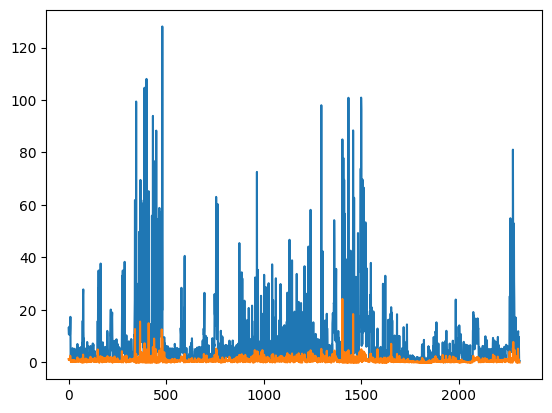

In [10]:
import matplotlib.pyplot as plt
plt.plot(_maxMarginQd,label='up')
plt.plot(_minMarginPd,label='down')

